# Involutional neural networks

<hr />

### Introduction

Convolution has been the basis of most modern neural networks for computer vision. A convolution kernel is spatial-agnostic and channel-specific. Because of this, it isn't able to adapt to different visual patterns with respect to different spatial locations. Along with location-related problems, the receptive field of convolution creates challenges with regard to capturing long-range spatial interactions.

To address the above issues, Li et. al. rethink the properties of convolution in <a href="https://arxiv.org/abs/2103.06255">Involution: Inverting the Inherence of Convolution for VisualRecognition</a>. The authors propose the "involution kernel", that is location-specific and channel-agnostic. Due to the location-specific nature of the operation, the authors say that self-attention falls under the design paradigm of involution.

This example describes the involution kernel, compares two image classification models, one with convolution and the other with involution, and also tries drawing a parallel with the self-attention layer.

<hr />

### Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# Set seed for reproducibility.
tf.random.set_seed(42)

2025-04-23 04:10:05.148039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745381405.174862  158468 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745381405.181627  158468 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745381405.204348  158468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745381405.204420  158468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745381405.204426  158468 computation_placer.cc:177] computation placer alr

<hr />

### Convolution

Convolution remains the mainstay of deep neural networks for computer vision. To understand Involution, it is necessary to talk about the convolution operation.

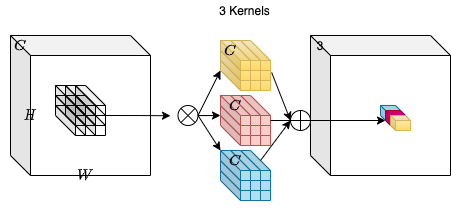

Consider an input tensor <b>X</b> with dimensions <b>H</b>, <b>W</b> and <b>C_in</b>. We take a collection of <b>C_out</b> convolution kernels each of shape <b>K</b>, <b>K</b>, <b>C_in</b>. With the multiply-add operation between the input tensor and the kernels we obtain an output tensor <b>Y</b> with dimensions <b>H</b>, <b>W</b>, <b>C_out</b>.

In the diagram above C_out=3. This makes the output tensor of shape H, W and 3. One can notice that the convoltuion kernel does not depend on the spatial position of the input tensor which makes it <b>location-agnostic. On the other hand, each channel in the output tensor is based on a specific convolution filter which makes is <b>channel-specific</b>.

<hr />

### Involution

The idea is to have an operation that is both <b>location-specific</b> and <b>channel-agnostic</b>. Trying to implement these specific properties poses a challenge. With a fixed number of involution kernels (for each spatial position) we will <b>not</b> be able to process variable-resolution input tensors.

To solve this problem, the authors have considered generating each kernel conditioned on specific spatial positions. With this method, we should be able to process variable-resolution input tensors with ease. The diagram below provides an intuition on this kernel generation method.

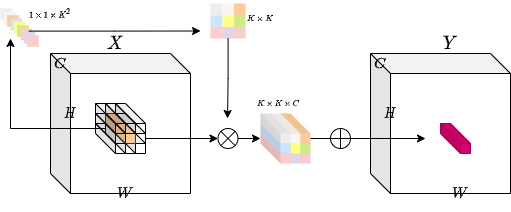

In [2]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

<hr />

### Testing the Involution layer

In [3]:
# Define the input tensor.
input_tensor = tf.random.normal((32, 256, 256, 3))

# Compute involution with stride 1.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2"
)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(input_tensor)

print("with channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape))

2025-04-23 04:15:08.697772: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-04-23 04:15:08.873452: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.
2025-04-23 04:15:08.895889: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.
2025-04-23 04:15:08.959971: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2025-04-23 04:15:09.566633: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.


with stride 1 ouput shape: (32, 256, 256, 3)
with stride 2 ouput shape: (32, 128, 128, 3)


2025-04-23 04:15:10.483722: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.


with channel 16 and reduction ratio 2 ouput shape: (32, 256, 256, 3)


<hr />

### Image Classification

In this section, we will build an image-classifier model. There will be two models one with convolutions and the other with involutions.

The image-classification model is heavily inspired by this <a href="https://www.tensorflow.org/tutorials/images/cnn">Convolutional Neural Network (CNN)</a> tutorial from Google.

<hr />

### Get the CIFAR10 Dataset

In [4]:
# Load the CIFAR10 dataset.
print("loading the CIFAR10 dataset...")
(
    (train_images, train_labels),
    (
        test_images,
        test_labels,
    ),
) = keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1.
(train_images, test_images) = (train_images / 255.0, test_images / 255.0)

# Shuffle and batch the dataset.
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .shuffle(256)
    .batch(256)
)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(256)

loading the CIFAR10 dataset...


<hr />

### Visualise the data

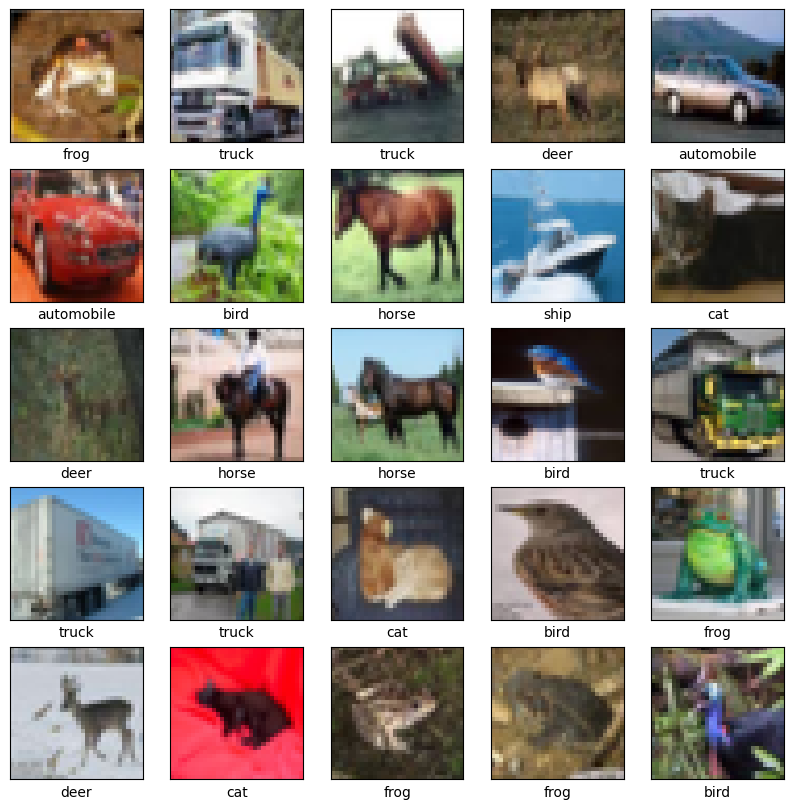

In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

<hr />

### Convolutional Neural Network

In [6]:
# Build the conv model.
print("building the convolution model...")
conv_model = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding="same"),
        keras.layers.ReLU(name="relu1"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu2"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu3"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10),
    ]
)

# Compile the mode with the necessary loss function and optimizer.
print("compiling the convolution model...")
conv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train the model.
print("conv model training...")
conv_hist = conv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the convolution model...
compiling the convolution model...
conv model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 47s 226ms/step - accuracy: 0.3077 - loss: 1.8853 - val_accuracy: 0.4911 - val_loss: 1.4334
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 84s 234ms/step - accuracy: 0.5297 - loss: 1.3165 - val_accuracy: 0.5929 - val_loss: 1.1588
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - accuracy: 0.6121 - loss: 1.1013 - val_accuracy: 0.6414 - val_loss: 1.0213
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 227ms/step - accuracy: 0.6559 - loss: 0.9888 - val_accuracy: 0.6361 - val_loss: 1.0478
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 223ms/step - accuracy: 0.6845 - loss: 0.9082 - val_accuracy: 0.6724 - val_loss: 0.9528
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - accuracy: 0.7088 - loss: 0.8395 - val_accuracy: 0.6853 - val_loss: 0.9236
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.7261 - loss: 0.7899 - val_accuracy: 0.7017 - val_loss: 0.8748
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.7412 - loss: 0.7475 - val

<hr />

### Involutional Neural Network

In [7]:
# Build the involution model.
print("building the involution model...")

inputs = keras.Input(shape=(32, 32, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_27']. Received: the structure of inputs=*
  warnings.warn(


196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.1727 - loss: 2.2468 - val_accuracy: 0.2736 - val_loss: 2.0249
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.3127 - loss: 1.8942 - val_accuracy: 0.3406 - val_loss: 1.8344
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.3562 - loss: 1.7766 - val_accuracy: 0.3694 - val_loss: 1.7609
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.3707 - loss: 1.7338 - val_accuracy: 0.3837 - val_loss: 1.7309
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.3850 - loss: 1.7029 - val_accuracy: 0.3886 - val_loss: 1.7085
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.3947 - loss: 1.6790 - val_accuracy: 0.3968 - val_loss: 1.6808
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.4022 - loss: 1.6589 - val_accuracy: 0.4037 - val_loss: 1.6644
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.4093 - loss: 1.6443 - val

<hr />

### Comparisons

In this section, we will be looking at both the models and compare a few pointers.

#### Parameters

One can see that with a similar architecture the parameters in a CNN is much larger than that of an INN (Involutional Neural Network).

In [8]:
conv_model.summary()

inv_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957,536 (3.65 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 638,358 (2.44 MB)

Model: "inv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inv_1 (Involution)              │ [(None, 32, 32, 3),    │            26 │
│                                 │ (None, 32, 32, 9, 1,   │               │
│                                 │ 1)]                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inv_2 (Involution)              │ [(None, 16, 16, 3),    │            26 │
│                                 │ (None, 16, 16, 9, 1,   │               │
│                                 │ 1)]                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inv_3 (Involution)              │ [(None, 8, 8, 3),      │            26 │
│                                 │ (None, 8, 8, 9, 1, 1)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,230 (153.25 KB)

 Trainable params: 13,074 (51.07 KB)

 Non-trainable params: 6 (24.00 B)

 Optimizer params: 26,150 (102.15 KB)

#### Loss and Accuracy Plots

Here, the loss and the accuracy plots demonstrate that INNs are slow learners (with lower parameters).

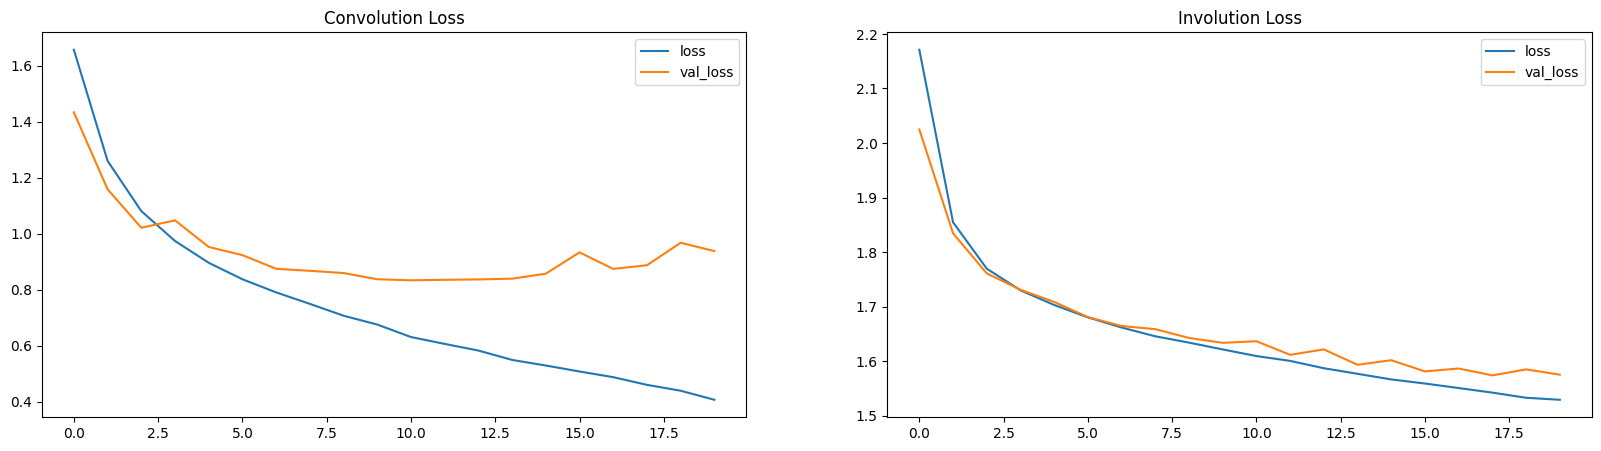

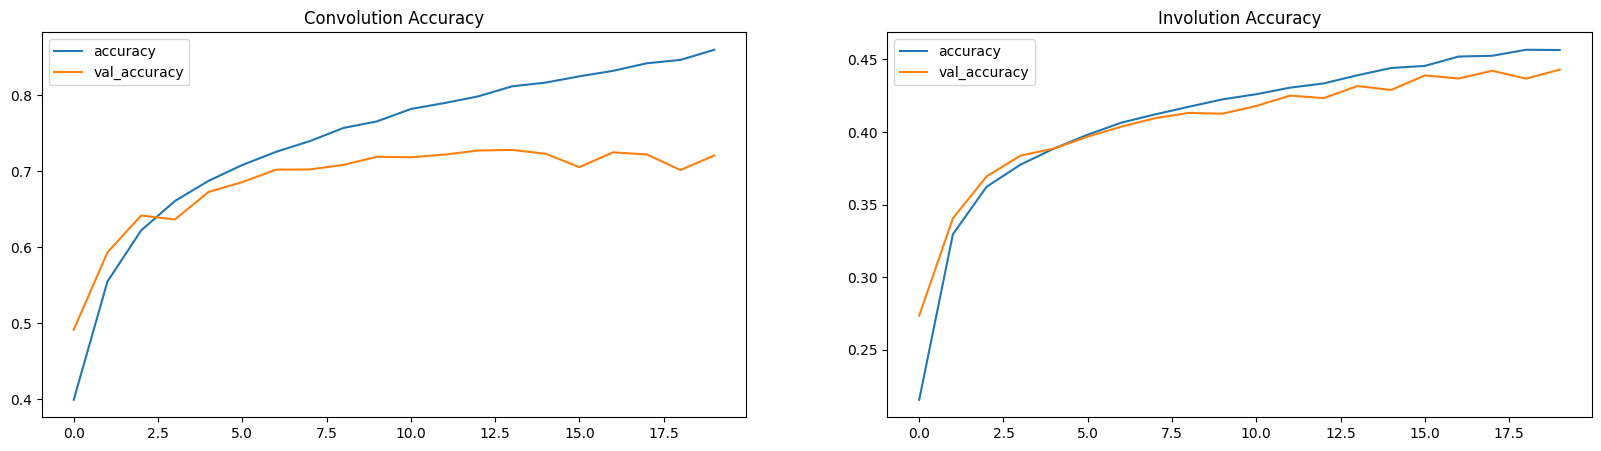

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_hist.history["loss"], label="loss")
plt.plot(conv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_hist.history["accuracy"], label="accuracy")
plt.plot(conv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.show()

<hr />

### Visualizing Involution Kernels

To visualize the kernels, we take the sum of K×K values from each involution kernel. <b>All the representatives at different spatial locations frame the corresponding heat map.</b>

The authors mention:

"Our proposed involution is reminiscent of self-attention and essentially could become a generalized version of it."

With the visualization of the kernel we can indeed obtain an attention map of the image. The learned involution kernels provides attention to individual spatial positions of the input tensor. The <b>location-specific</b> property makes involution a generic space of models in which self-attention belongs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


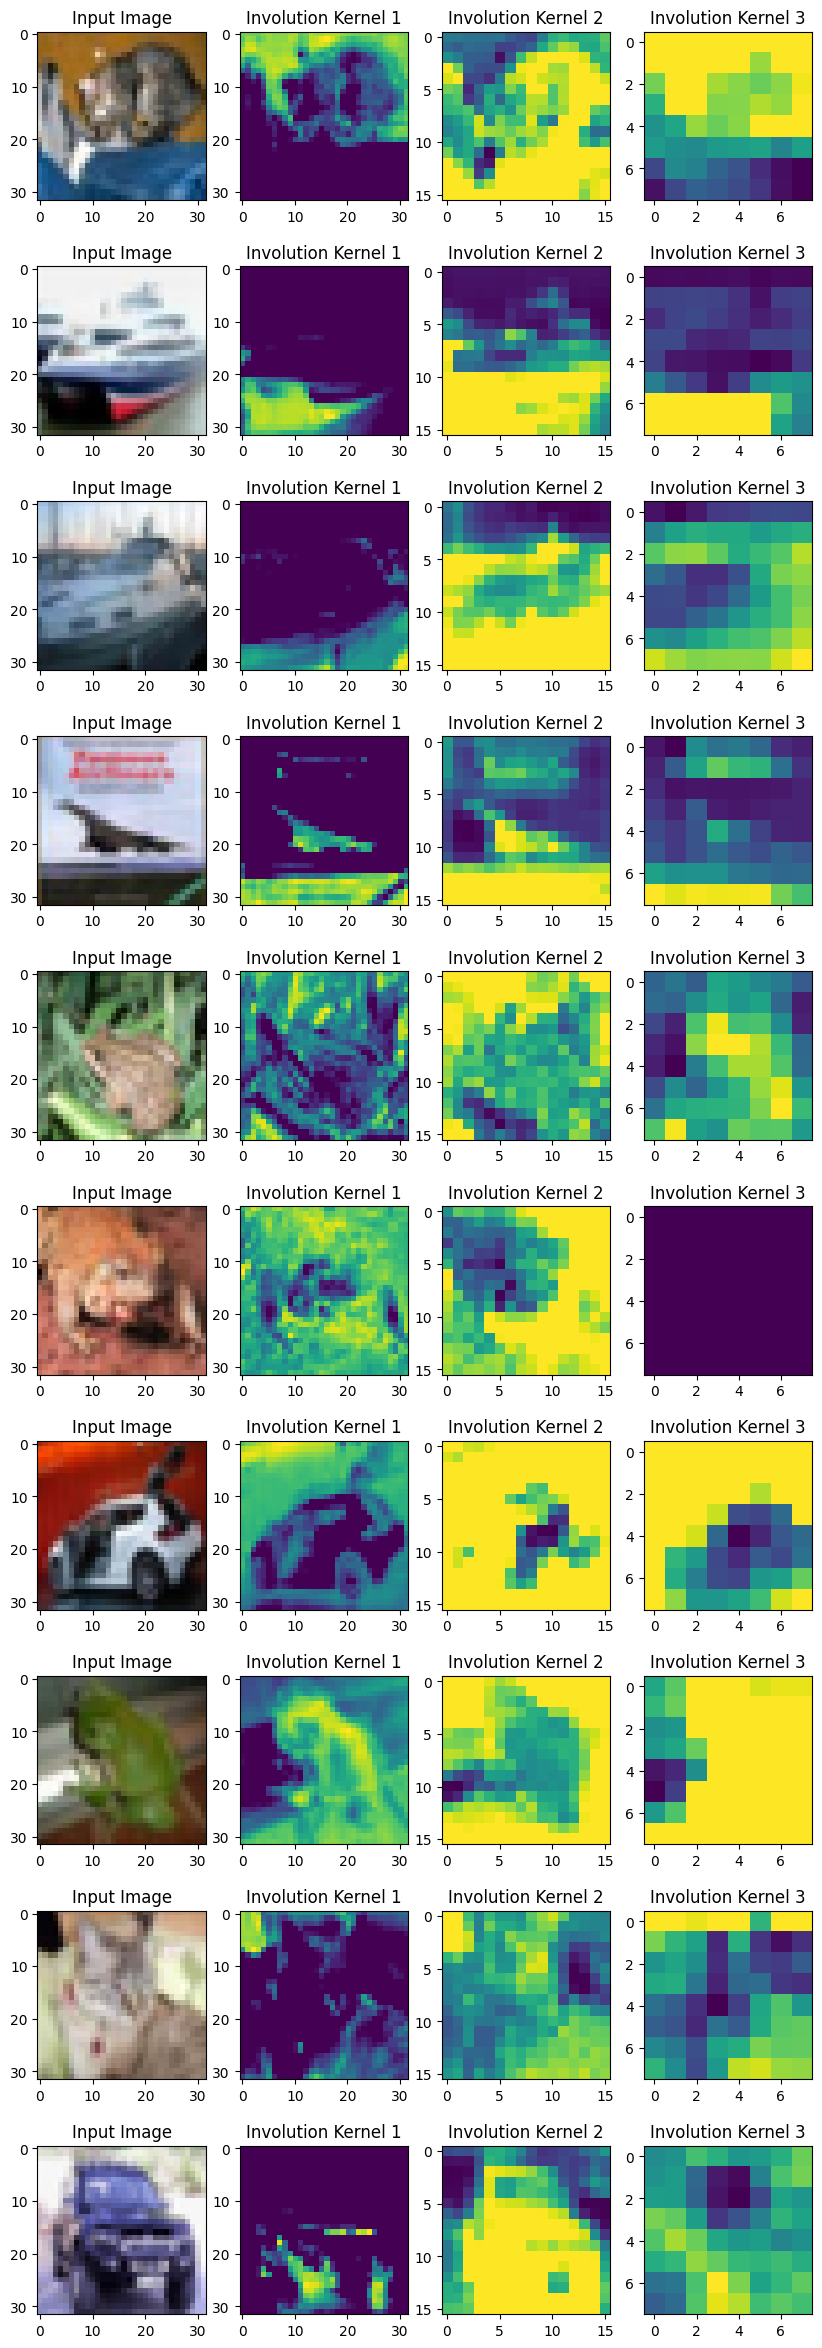

In [10]:
layer_names = ["inv_1", "inv_2", "inv_3"]
outputs = [inv_model.get_layer(name).output[1] for name in layer_names]
vis_model = keras.Model(inv_model.input, outputs)

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

for ax, test_image in zip(axes, test_images[:10]):
    (inv1_kernel, inv2_kernel, inv3_kernel) = vis_model.predict(test_image[None, ...])
    inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
    inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
    inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])

    ax[0].imshow(keras.utils.array_to_img(test_image))
    ax[0].set_title("Input Image")

    ax[1].imshow(keras.utils.array_to_img(inv1_kernel[0, ..., None]))
    ax[1].set_title("Involution Kernel 1")

    ax[2].imshow(keras.utils.array_to_img(inv2_kernel[0, ..., None]))
    ax[2].set_title("Involution Kernel 2")

    ax[3].imshow(keras.utils.array_to_img(inv3_kernel[0, ..., None]))
    ax[3].set_title("Involution Kernel 3")

<hr />

### Conclusions

In this example, the main focus was to build an Involution layer which can be easily reused. While our comparisons were based on a specific task, feel free to use the layer for different tasks and report your results.

According to me, the key take-away of involution is its relationship with self-attention. The intuition behind location-specific and channel-spefic processing makes sense in a lot of tasks.

Moving forward one can:

<ul>
    <li>Look at <a href="https://youtu.be/pH2jZun8MoY">Yannick's video</a> on involution for a better understanding.</li>
    <li>Experiment with the various hyperparameters of the involution layer.</li>
    <li>Build different models with the involution layer.</li>
    <li>Try building a different kernel generation method altogether.</li>
</ul>

You can use the trained model hosted on <a href="https://huggingface.co/keras-io/involution">Hugging Face Hub</a> and try the demo on <a href="https://huggingface.co/spaces/keras-io/involution">Hugging Face Spaces</a>.